In [1]:
import numpy as np
import scipy as sp
import matplotlib.colors as colors
from matplotlib.pyplot import cm
from scipy.integrate import simps
from time import time 
import matplotlib.animation as animation
import importlib
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers
import os
import astropy.units as u
import matplotlib
import scipy.constants as cst
# Set plot parameter
from matplotlib.figure import Figure
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import h5py
import os
import tracemalloc
import time
import argparse
from astropy.wcs import WCS
from astropy.coordinates import Angle
from astropy. io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scan_fcts import * 
from TIM_scan_strategy import *
from strategy import *

In [2]:
P = load_params('params_strategy.par')

In [3]:
#Initiate the parameters

simu_sky_path = P['path']+P['file']
tod_file=P['path']+'TOD_'+P['file'][:-5]+'.hdf5'


#The coordinates of the field
name=P['name_field']
c=SkyCoord.from_name(name)
ra = c.ra.value
dec = c.dec.value
#The contour of the field
contours = P['contours']
x_cen, y_cen = np.mean(contours[:, 1]), np.mean(contours[:, 0])
lat = P['latittude']
f_range = P['f_range']

#Load the resolution. 
#if not in params, load it from the map used to generate the TOD. 
res = P['res']
if(res is None):
    hdr = fits.getheader(P['path']+P['file'])
    res = (hdr['CDELT1'] * u.Unit(hdr['CUNIT1'])).to(u.deg).value

#Scan parameters
stripe_size = P['stripe_size'] #the lenght of one constant elevation strip in degree
dy = P['dy'] #the step in elevation between two consecutive constant elevation strip in degree
nb_rows = P['nb_rows'] #the number of step to be done
T_duration = P['T_duration'] * 3600 #second angle, duration of the scan.
dt = P['dt']*np.pi/3.14 #second angle, such as dt is not rational. Aquisition rate. 

theta = np.radians(P['theta'])

#Pixel offsets from the center of the field of view in degree. 
pixel_offset_HW = pixelOffset(P['nb_pixel_HW'], P['offset_HW']) 
pixel_offset_LW = pixelOffset(P['nb_pixel_LW'], P['offset_LW']) 
pixel_offset = pixel_offset_HW

In [4]:
#Generate the sacan path
T = np.arange(0,T_duration,dt)
HA = np.arange(-T_duration/2,T_duration/2,dt) / 3600 # hours angle
az, alt = az_scan_custom(np.radians(stripe_size),np.radians(dy),nb_rows)
az = np.degrees(az); alt=np.degrees(alt)
scan_path, _  = genScanPath(T, alt, az, np.zeros(len(alt)))   
scan_path_sky = genPointingPath(T, scan_path, HA, lat, dec)
pixel_paths  = genPixelPath(scan_path, pixel_offset, theta)
pointing_paths = [genPointingPath(T, pixel_path, HA, lat, dec) for pixel_path in pixel_paths]
xedges,yedges,hit_map = binMap(pointing_paths,res=res,f_range=f_range,dec=dec,)


/tmp/ipykernel_29793/24350570.py:19: UserWarning: The following kwargs were not used by contour: 'lw'
  CS = axr.contour(np.roll(np.sqrt(hit_map*np.roll(hit_map, 4, axis=1)),-2,axis=1), levels=[0.5*np.max(hit_map)], lw=0.5, origin='lower', linewidths=0.6,
/tmp/ipykernel_29793/24350570.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axp.scatter(pointing_paths[i][::n,0]+ra, pointing_paths[i][::n,1], s=0.1,c=c)


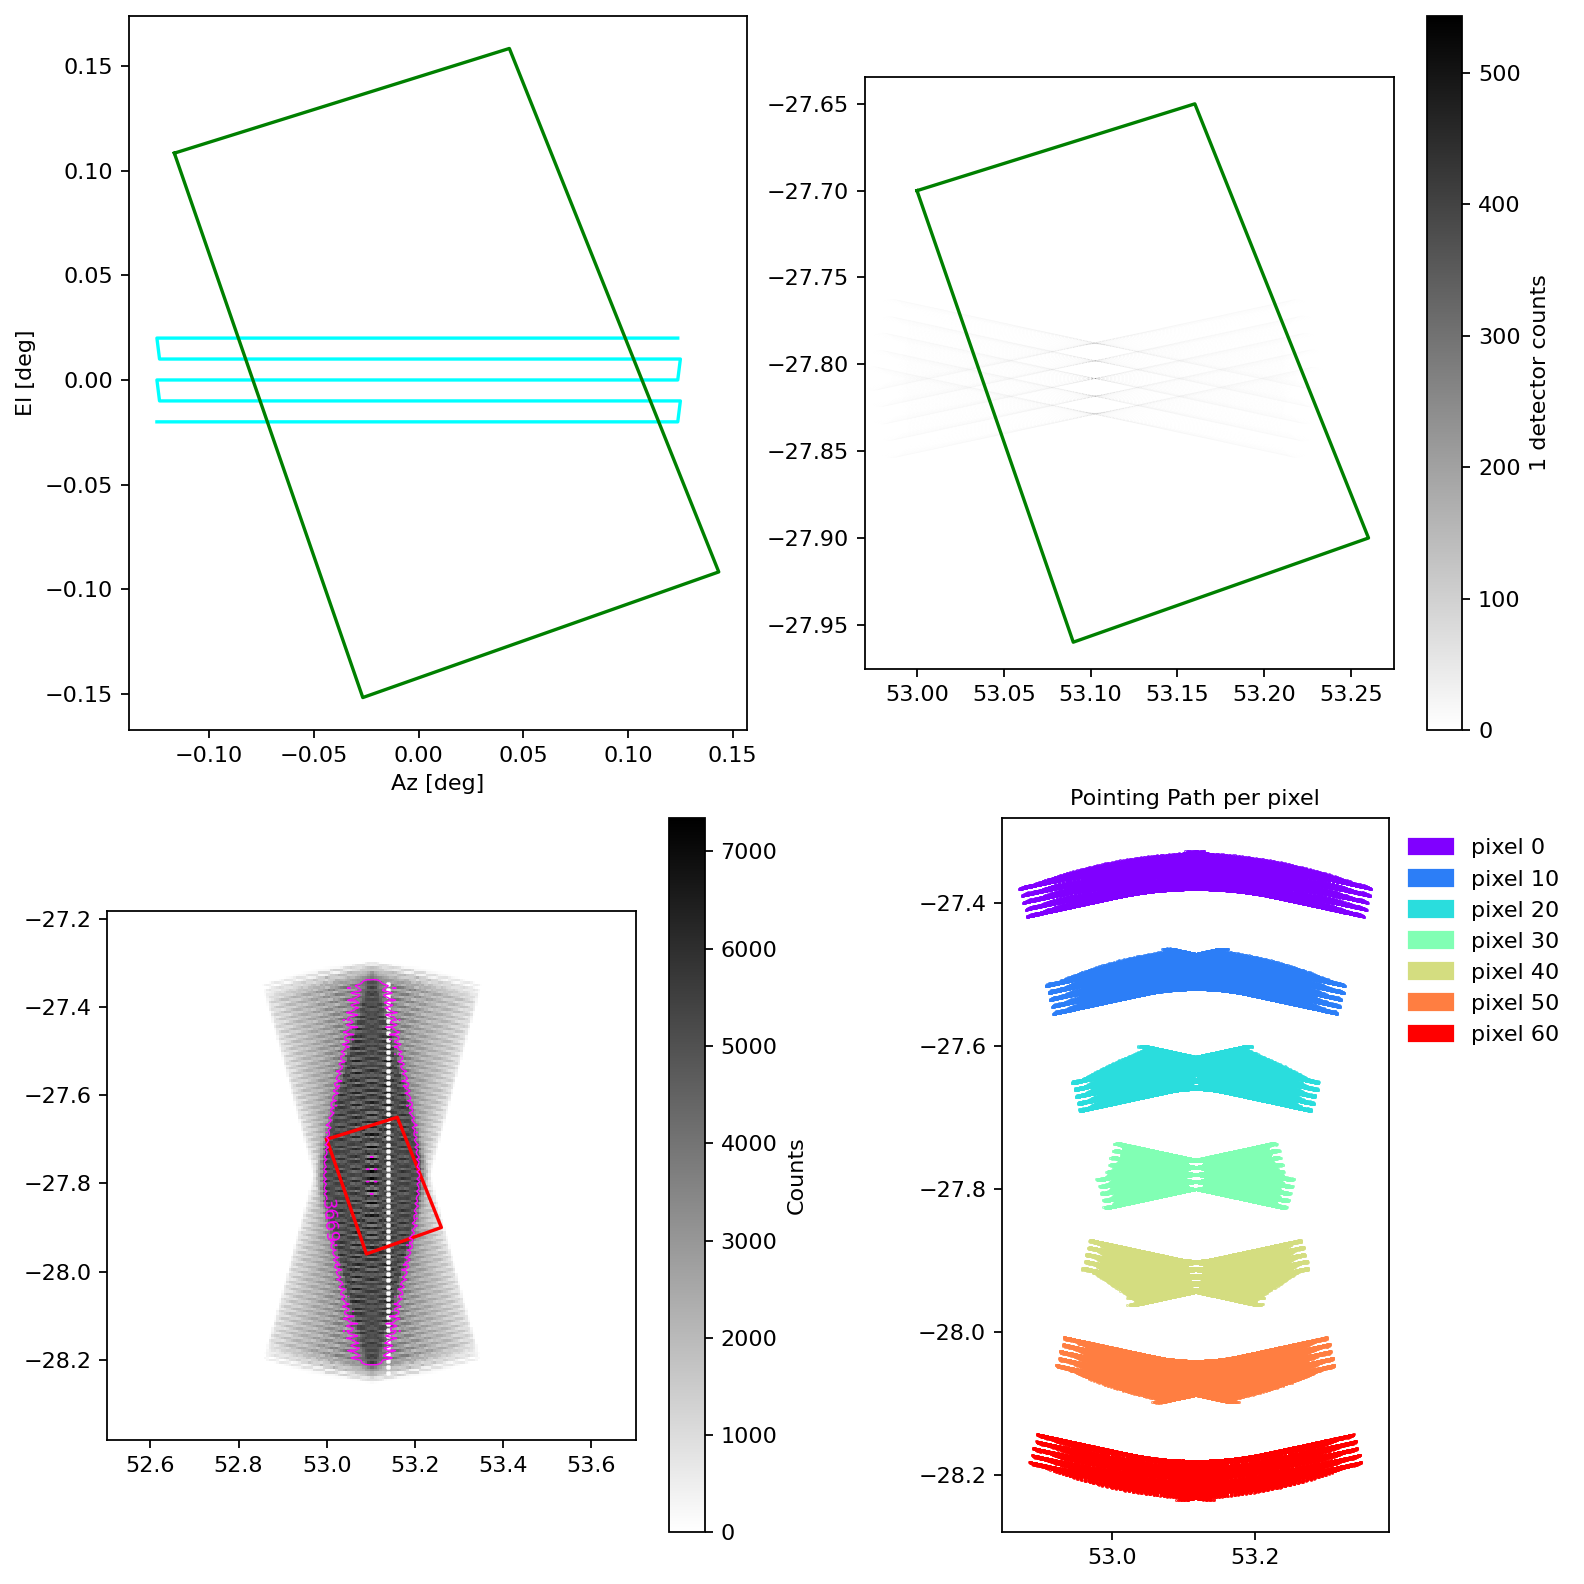

In [5]:
#scan route
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, axs = plt.subplots(2,2,figsize=(10,10), dpi=160,)# sharey=True, sharex=True)
axradec, ax, axr, axp = axs[0,0], axs[0,1], axs[1,0], axs[1,1]
axradec.plot(az-az.max()/2,alt-alt.max()/2,'cyan')
if(contours is not None): axradec.plot(contours[:, 1]-ra, contours[:, 0]-dec, c='g' )
axradec.set_xlabel('Az [deg]')
axradec.set_ylabel('El [deg]')
axradec.set_aspect(aspect=1)
if(contours is not None): heatmap, xedges, yedges = np.histogram2d(scan_path_sky[:,0]+contours[:, 1].mean(), scan_path_sky[:,1], bins=int(2/res))
else: heatmap, xedges, yedges = np.histogram2d(scan_path_sky[:,0], scan_path_sky[:,1], bins=int(2/res))
im = ax.imshow(heatmap.T, origin='lower', cmap='binary',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
cbar = fig.colorbar(im, ax=ax, label='1 detector counts')
if(contours is not None): ax.plot(contours[:, 1], contours[:, 0], c='g' )
img = axr.imshow((hit_map), extent=[x_cen-f_range, x_cen+f_range,y_cen-f_range, y_cen+f_range,], 
                interpolation='nearest', origin='lower', vmin=0, vmax=np.max(hit_map), cmap='binary' )
if(contours is not None): axr.plot(contours[:, 1], contours[:, 0], c= 'r')
fig.colorbar(img, ax=axr, label='Counts')
CS = axr.contour(np.roll(np.sqrt(hit_map*np.roll(hit_map, 4, axis=1)),-2,axis=1), levels=[0.5*np.max(hit_map)], lw=0.5, origin='lower', linewidths=0.6,
            extent=[x_cen-f_range, x_cen+f_range,y_cen-f_range, y_cen+f_range,], colors='magenta')
# CS = ax1.contour(hit_map, levels=[0.5*np.max(hit_map)], lw=0.5, origin='lower', linewidths=0.6,\
#             extent=[x_cen-maps, x_cen+maps,y_cen-maps, y_cen+maps,], colors='w')
ax.clabel(CS, inline=1, fontsize=8, )
#pixel_xy = np.array([-1*pixel_offset*np.sin(theta)-0.036*np.cos(theta), pixel_offset*np.cos(theta)-0.036*np.sin(theta)])
pixel_xy = np.array([-1*pixel_offset*np.sin(theta)+0.036*np.cos(theta), pixel_offset*np.cos(theta)+0.072*np.sin(theta)])
axr.scatter(pixel_xy[0]+x_cen, pixel_xy[1]+y_cen, s=2, marker='+', c='white',label='SW Spatial Pixels')
patchs = []
axp.set_title('Pointing Path per pixel')
idx = np.arange(len(pixel_paths))[::10]
n = 11
for i,c in zip(idx, cm.rainbow(np.linspace(0.,1,len(idx)))):
    axp.scatter(pointing_paths[i][::n,0]+ra, pointing_paths[i][::n,1], s=0.1,c=c)
    patch = mpatches.Patch(color=c, label= 'pixel %d'%i); patchs.append(patch); 
axp.set_aspect(aspect=1)
axp.legend(handles=patchs,frameon=False, bbox_to_anchor=(1,1))
fig.tight_layout()
plt.savefig("scan_route.png")
plt.show()


/home/mvancuyck/Desktop/my_TIM_analysis/namap_and_scan_strategy/strategy.py:194: RuntimeWarning: invalid value encountered in divide
  hist /= norm


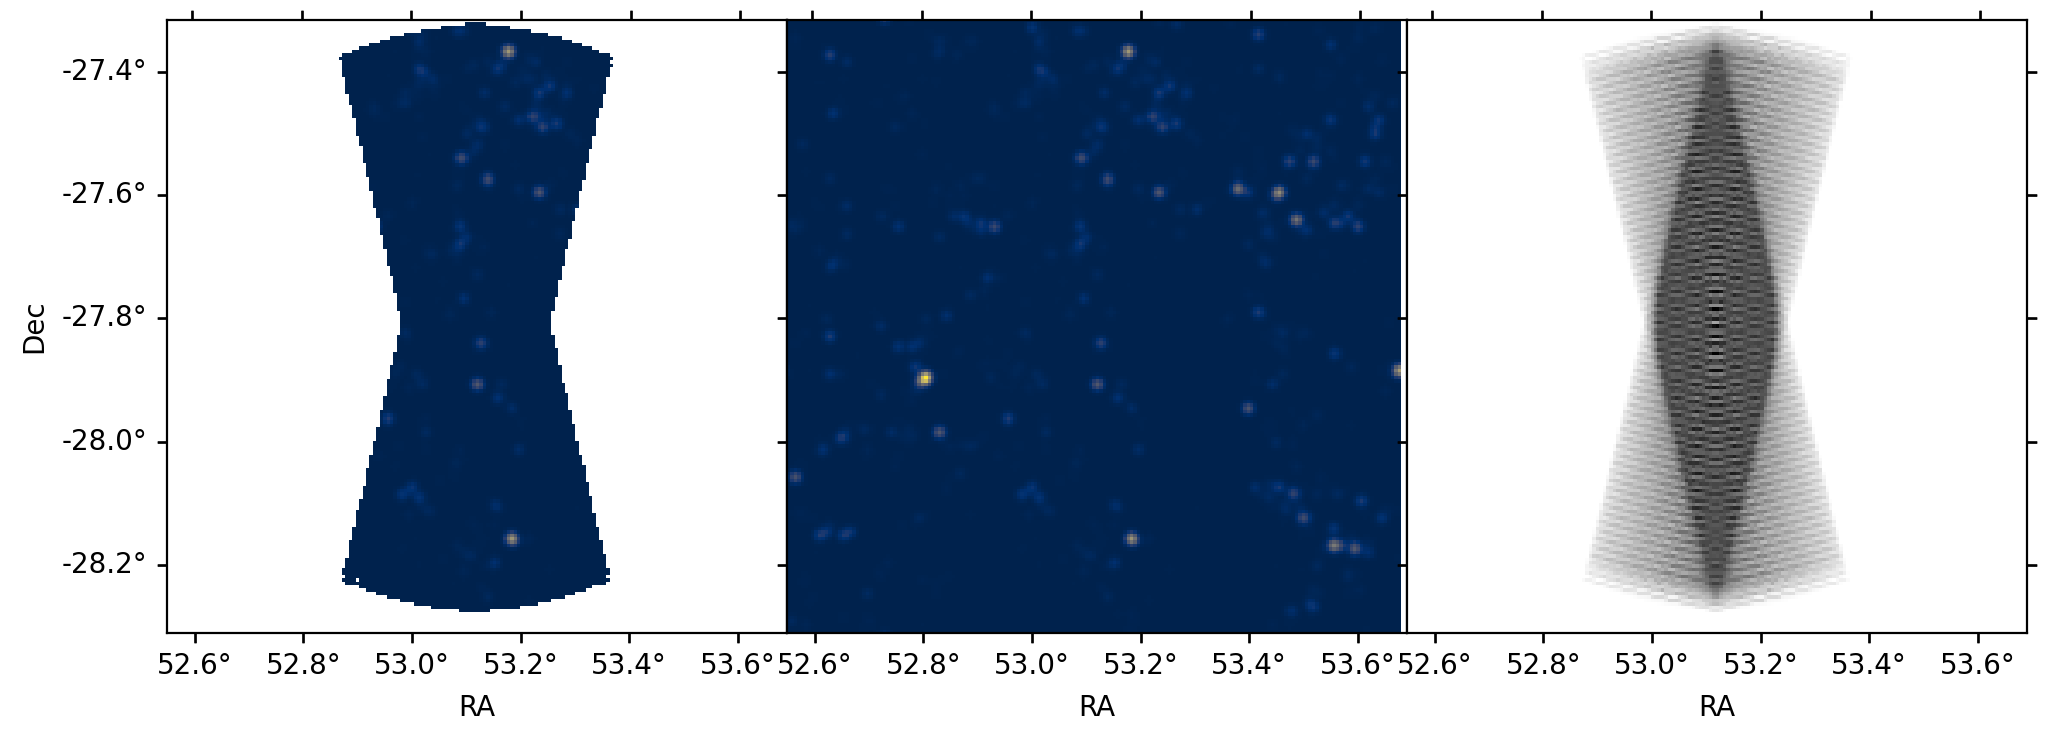

In [6]:
#Generate the TOds and save it in hdf5
simu_sky_path = P['path']+P['file']
positions_y, positions_x, samples = gen_tod_one_array(simu_sky_path, pixel_offset,pointing_paths, ra, dec)
tod_file=P['path']+'TOD_'+P['file'][:-5]+'.hdf5'
save_tod_one_array(tod_file, scan_path_sky, samples, pixel_offset, T, spf=P['spf'])